# Models
1. Lyrics
2. Cover Art
3. Music

## Libraries

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import utils
pd.options.display.max_rows = 999

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import gc

import fastcore

from fastai2.data.all import *
from fastai2.tabular.all import *
from fastai2.tabular.model import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *
from fastai2.basics import *
from fastai2.vision.all import *

# images
from torchvision.models import inception_v3, googlenet, wide_resnet50_2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# timeseries
from tsai.all import *
package_versions()
hardware_details()

tsai       : 0.1.0
fastai2    : 0.0.17
fastcore   : 0.1.18
torch      : 1.4.0
scipy      : 1.4.1
numpy      : 1.18.1
pandas     : 1.1.0
Total RAM  :  29.44 GB
Used RAM   :   1.38 GB
n_cpus     : 8
device     : cuda (Quadro M4000)


In [2]:
# set seed for reproducibility
set_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model metrics
precision = Precision(average='macro')
precision2 = Precision(average='weighted')

## Test-train file

In [3]:
dt = pd.read_csv('processing/test_train_split.csv')
dt.head()

,track_id,genre,has_musical_ftr,has_lyrics,image_name,has_cover_img,cover_id,is_test
0,TRAAAAV128F421A322,Punk,1,1.0,4b3cc7ae-654e-4408-89e1-4ea70cf86717,1.0,70206.0,0
1,TRAAAEF128F4273421,Pop_Indie,1,1.0,c1f9b340-a37e-4dc8-aaf9-f622c5457f1a,1.0,21597.0,0
2,TRAAAHJ128F931194C,Pop_Indie,1,1.0,dc9b75f9-d5e7-434a-82c4-0d4e9790efd4,1.0,1330.0,0
3,TRAAAHZ128E0799171,Hip_Hop_Rap,1,1.0,62a1cd53-1339-4f04-8113-287b174c3917,1.0,33631.0,2
4,TRAAAJG128F9308A25,Country_Traditional,1,1.0,0cee21c0-9657-469c-9a72-b81bacc88eee,1.0,40306.0,1


## Lyrics Model (fastai2)
* fastai examples: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson4-tabular.ipynb
* something odd with tabular learner: https://github.com/muellerzr/fastai-Experiments-and-tips/blob/master/Test%20Set%20Generation/Labeled_Test_Set.ipynb
* fastai2 discussion: https://forums.fast.ai/t/a-walk-with-fastai2-tabular-study-group-and-online-lectures-megathread/64361/6

* tabular basic fastai2 example: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/01_Adults.ipynb
* hidden layer size: https://forums.fast.ai/t/an-attempt-to-find-the-right-hidden-layer-size-for-your-tabular-learner/45714
* multiclass metrics: https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2


### data import and transformation

In [4]:
# data import
path = '/storage/thesis/lyrics/'
file = 'lyrics_piv_trunc.csv'

d = pd.read_csv(path+file, index_col=0, nrows=500)
dtypes = {e: np.float32 for e in d.columns[1:-1].tolist()}

df = pd.DataFrame()
for d in pd.read_csv(path+file, index_col=0, chunksize=7000, dtype=dtypes):
    df = pd.concat([df, d])

# filter
if file in ['lyrics_piv_tfidf.csv','lyrics_piv_trunc.csv']:
    df = (df.merge(dt[['track_id','is_test','genre']], how='inner', on=['track_id']))
else:
    df = (df.drop('genre', axis=1)
            .merge(dt[['track_id','is_test','genre']], how='inner', on=['track_id']))
    
# fill nulls
num_cols = [c for c in df.columns if c != 'genre' and c != 'track_id']
df.loc[:, num_cols] = df.loc[:, num_cols].fillna(0)

# scale so continuous features go to 0-1
scaler = MinMaxScaler()
cont_vars = [c for c in df.columns if c not in ['track_id','is_test','genre']]

scaler.fit(df.loc[df['is_test']==0, cont_vars]) # fit scaler on train only
df.loc[:, cont_vars] = scaler.transform(df.loc[:, cont_vars]) # transform all data

### Model

In [5]:
dep_var = 'genre'
procs = []

# splits
splits = (L(df.loc[df['is_test']==0,:].index.tolist()), L(df.loc[df['is_test']==1,:].index.tolist()))
y_block = CategoryBlock()

# data loader
to = TabularPandas(df, 
                   procs=procs, 
                   cont_names=cont_vars, 
                   y_names=dep_var, 
                   y_block=y_block,
                   splits=splits, 
                   reduce_memory=False)
dls = to.dataloaders(bs=64)

In [6]:
## [200, 100] // weight decay: 0.1

learn1 = tabular_learner(dls, layers=[200,100], wd=0.1, metrics=[precision, precision2, accuracy])
# learn1.lr_find(start_lr = 1e-7, end_lr = 1, num_it = 100)
learn1.fit_one_cycle(10, lr_max=5e-3)

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.479918,3.192479,0.201617,0.205894,0.226213,00:08
1,2.488103,2.857846,0.214470,0.218307,0.212361,00:08
2,2.465342,2.987547,0.222839,0.230193,0.216278,00:08
3,2.400266,2.873135,0.210094,0.226097,0.241020,00:08
4,2.341690,3.109445,0.275398,0.238883,0.215896,00:08
5,2.249963,8.285290,0.226940,0.230751,0.224494,00:08
6,2.153957,4.641259,0.224298,0.229421,0.216278,00:08
7,2.015261,4.148859,0.225893,0.230993,0.214845,00:08
8,1.849082,11.235824,0.219658,0.229247,0.215227,00:08
9,1.773961,4.076801,0.216290,0.225156,0.211502,00:08


/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
## [100, 50] // weight decay: 0.1
learn1 = tabular_learner(dls, layers=[100,50], wd=0.1, metrics=[precision, precision2, accuracy])
learn1.fit_one_cycle(10, lr_max=5e-3)

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.494320,2.715968,0.226787,0.238460,0.233856,00:08
1,2.475036,4.365393,0.183711,0.206099,0.222010,00:08
2,2.449497,2.790155,0.203572,0.215316,0.230894,00:08
3,2.386110,3.436927,0.200006,0.215123,0.226022,00:08
4,2.347135,2.825617,0.214182,0.215988,0.227551,00:08
5,2.293856,2.907496,0.223140,0.227681,0.238154,00:08
6,2.217500,3.763973,0.207185,0.218803,0.226213,00:08
7,2.122211,6.293671,0.214971,0.222634,0.222870,00:08
8,2.061622,4.001686,0.212547,0.219709,0.219717,00:08
9,1.995177,3.739333,0.213470,0.224022,0.222392,00:08


In [6]:
## [36, 18, 9] // weight decay: 0
learn = tabular_learner(dls, layers=[36,18,9], metrics=[precision, precision2, accuracy])
learn.fit_one_cycle(10, lr_max=1e-2)

# learn.save('lyrics_2');
# learn.load('lyrics_2');

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.602054,2.897865,0.110565,0.143599,0.205197,00:10
1,2.525351,2.945875,0.124897,0.164952,0.217902,00:09
2,2.497919,2.812418,0.176875,0.202114,0.212553,00:09
3,2.463565,2.679108,0.186924,0.204334,0.229079,00:09
4,2.414439,2.804714,0.172713,0.191912,0.219622,00:09
5,2.379920,4.480861,0.181194,0.204359,0.238632,00:09
6,2.362655,3.255640,0.180652,0.205870,0.233282,00:09
7,2.337885,2.876170,0.189577,0.213552,0.233569,00:09
8,2.295731,4.692622,0.184670,0.211232,0.233951,00:09
9,2.289737,2.837354,0.182058,0.203665,0.235766,00:09


/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
learn.load('lyrics_2');
learn.final_record

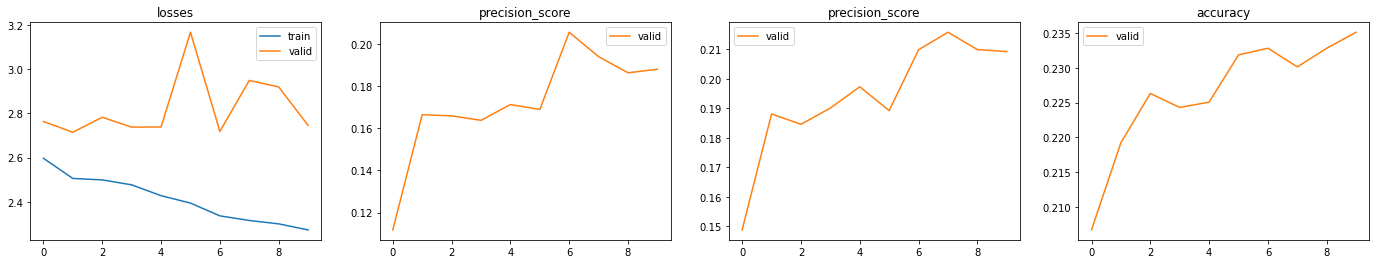

In [9]:
learn.recorder.plot_metrics(ncols=4)

### Model Interpretation

/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


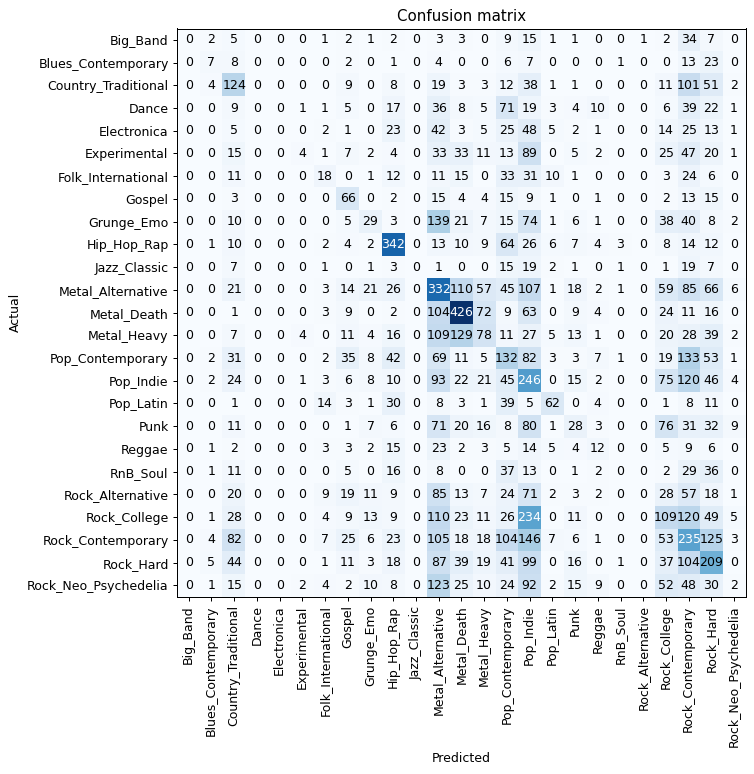

In [10]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_confusion_matrix(figsize=(8.5,8.5), dpi=90) # no class balance, small architecture

### Export Probabilities

In [11]:
# create datasets for probabilities
dls_train = learn.dls.test_dl(df.loc[df['is_test']==0, :])
dls_valid = learn.dls.test_dl(df.loc[df['is_test']==2, :])

In [12]:
train_probs = learn.get_preds(dl=dls_train, reorder=True)[0]
test_probs = learn.get_preds(ds_idx=1, reorder=True)[0]
valid_probs = learn.get_preds(dl=dls_valid, reorder=True)[0]

# translate codes into genres
i2o = dict((v,k) for k,v in dls.vocab.o2i.items())
pred_cols = [k for k in dls.vocab.o2i.keys()]

/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# for train, test, valid, compute probabilities
lyr_pred_df = pd.DataFrame()
for d,l,p  in zip([dls_train.train, dls.valid, dls_valid.train],
                       ['train','test','valid'],
                       [train_probs, test_probs, valid_probs]):
    pred = d.items[['track_id','genre']].reset_index(drop=True).assign(src=l)
    pred['genre'] = pred['genre'].map(lambda s: i2o[s])
    probs = pd.DataFrame(np.asarray(p.cpu()), columns=pred_cols)
    pred = pd.concat([pred, probs], axis=1)
    
    # append to final df
    lyr_pred_df = pd.concat([lyr_pred_df, pred])
lyr_pred_df.to_csv('model_prs/lyrics.csv')

## Images (fastai2)
* https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb
* https://www.kaggle.com/muellerzr/fastai2-tabular-vision-starter-kernel

Two examples of the implementations of heatmaps for images:
https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb
https://github.com/fastai/fastai2/blob/master/nbs/course/lesson6-pets-more.ipynb

In [14]:
# torch.cuda.empty_cache()

In [4]:
look = pd.read_csv('processing/test_train_split.csv')
look_fnl = (look.loc[look['is_test'].isin([0,1]), :]
                .assign(tags=look.genre,
                        is_test=look.is_test.astype(bool))
                .drop(['track_id','has_musical_ftr','has_lyrics','has_cover_img','cover_id','genre'], axis=1)
                .drop_duplicates()
                .reset_index(drop=True)
                .loc[:, ['image_name','tags','is_test']])
look_fnl.head()

,image_name,tags,is_test
0,4b3cc7ae-654e-4408-89e1-4ea70cf86717,Punk,False
1,c1f9b340-a37e-4dc8-aaf9-f622c5457f1a,Pop_Indie,False
2,dc9b75f9-d5e7-434a-82c4-0d4e9790efd4,Pop_Indie,False
3,0cee21c0-9657-469c-9a72-b81bacc88eee,Country_Traditional,True
4,a3a9da0d-1a5e-446d-adac-64523f7bdeb5,Pop_Contemporary,False


In [5]:
# # move validate to diff folder
# from shutil import copyfile
# import os

# img_arr = [i+'.jpg' for i in look.loc[look['is_test']==2, 'image_name'].unique().tolist()]
# base_path = '/storage/thesis/covers/'
# for i in img_arr:
#     copyfile(base_path+i, base_path+'validate/'+i)

In [6]:
batch_tfms = aug_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0., do_flip=False)

np.random.seed(42)
path = '/storage/thesis'
dls = ImageDataLoaders.from_df(look_fnl, 
                               '/storage/thesis/',
                               folder='covers',
                               suff='.jpg',
                               valid_col='is_test',
                               bs=64,
                               num_workers=0,
                               batch_tfms=[*batch_tfms, Normalize.from_stats(*imagenet_stats)], 
                               item_tfms=Resize(256))

In [18]:
learn = cnn_learner(dls, resnet34, metrics=[precision, accuracy]).to_fp16()
# learn.lr_find()
learn.fit_one_cycle(5, lr_max=1e-3)
learn.save('vision_1');

learn.load('vision_1')

In [8]:
learn = cnn_learner(dls, resnet34, metrics=[precision, accuracy]).to_fp16()
learn.load('vision_1')
# learn.model

In [22]:
learn2 = cnn_learner(dls, resnet50, metrics=[precision, accuracy]).to_fp16()
# learn2.lr_find()
learn2.fit_one_cycle(5, lr_max=1e-3)
learn2.save('vision_2');

learn2.load('vision_2');

epoch,train_loss,valid_loss,precision_score,accuracy,time
0,4.169135,3.358512,0.126909,0.170019,11:39
1,3.408360,3.020316,0.114559,0.151341,11:40
2,2.934021,2.944608,0.119903,0.176245,11:41
3,2.550756,2.901934,0.127471,0.179598,11:41
4,2.335903,2.902232,0.129450,0.172414,11:49


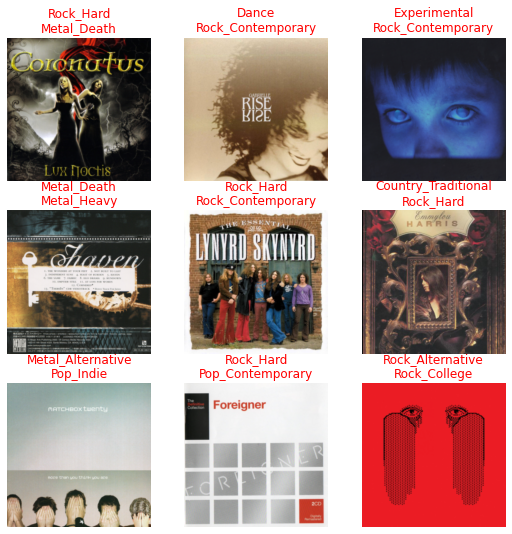

In [15]:
learn.show_results()

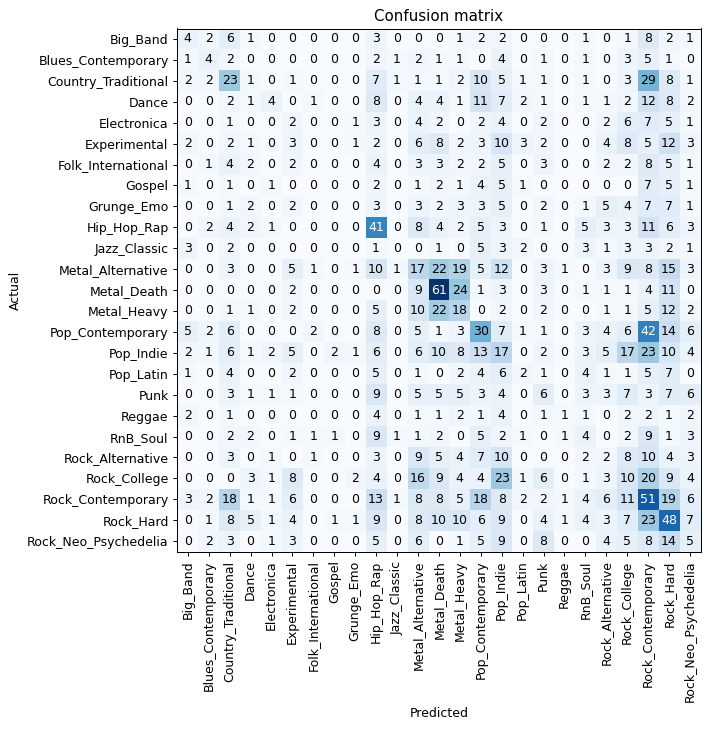

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=90)

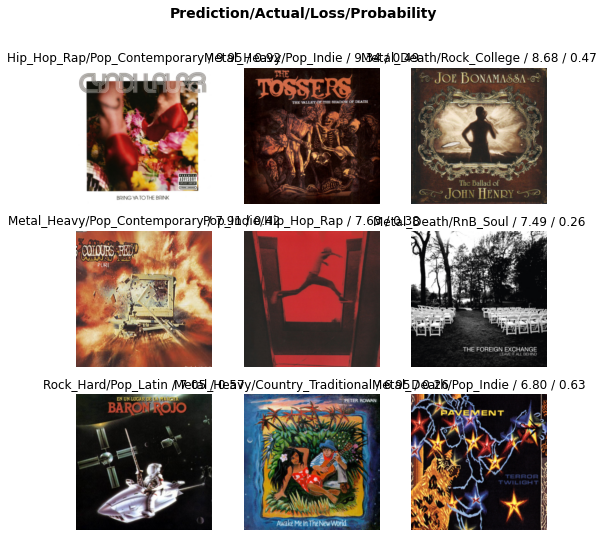

In [25]:
interp.plot_top_losses(9, figsize=(8.5,8.5))

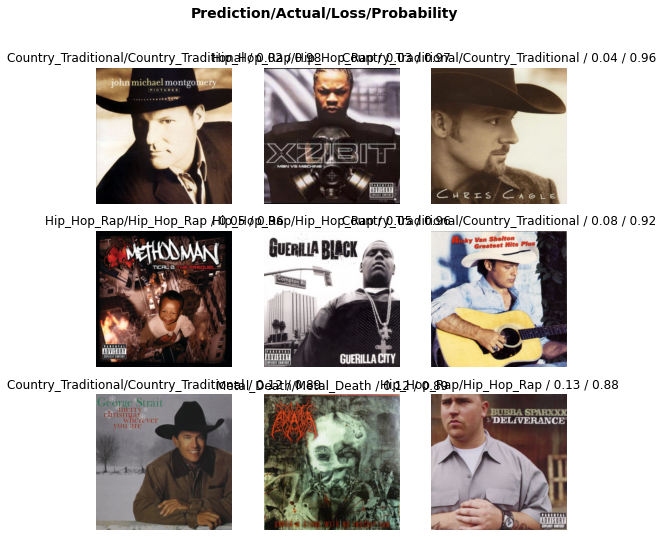

In [26]:
interp.plot_top_losses(9, largest=False, figsize=(8.5,8.5))

In [27]:
# import sqlite3

# conn = sqlite3.connect('/storage/thesis/music/AdditionalFiles/track_metadata.db')
# songs = pd.read_sql_query("""
#     SELECT * 
#     FROM songs 
#     WHERE 1=1
#         and artist_name like 'Saul Williams' 
#        and release = 'Amethyst Rock Star' 
# """, conn)
# songs
# dt.loc[dt['track_id'].isin(songs['track_id'].tolist()), 'image_name'].drop_duplicates().values[0]

In [28]:
# heatmap example
# https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb

In [18]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [19]:
i2o = dict((v,k) for k,v in dls.vocab.o2i.items())
print(i2o[2], i2o[9])

Country_Traditional Hip_Hop_Rap


In [20]:
def plot_activations(fname, cls):
    img = PILImage.create('/storage/thesis/covers/{0}.jpg'.format(fname))
    x, = first(dls.test_dl([img]))

    with HookBwd(learn.model[0]) as hookg:
        with Hook(learn.model[0]) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0,cls].backward()
        grad = hookg.stored
        
    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    
    x_dec = TensorImage(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

### Country_Traditional

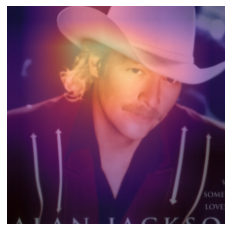

In [40]:
plot_activations('633c582d-9a7f-43b4-9b3f-0be287301634', 2)

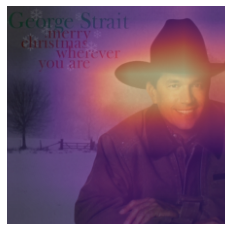

In [41]:
plot_activations('b55ca6f8-715b-30e2-8aae-e527803db909', 2)

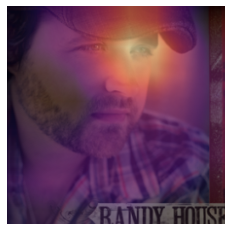

In [42]:
plot_activations('55e67f8a-5897-4987-b943-f437bd2d87d3', 2)

### Hip_Hop_Rap

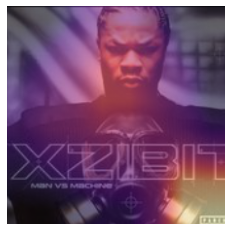

In [43]:
plot_activations('9e3e9586-f946-4895-8d09-7ddba20a6a38', 9)

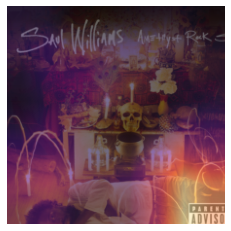

In [44]:
plot_activations('d23bd8bc-44f4-452d-b3c7-0ef0411ffbe7', 9)

### Experimental

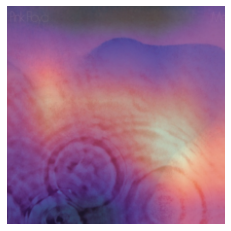

In [54]:
plot_activations('09ed5877-bb22-4a26-8ec7-c95e5ee70fd3', 5)

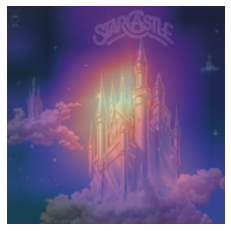

In [55]:
plot_activations('d774ed72-8283-426a-b1d2-aafe261cb490', 5)

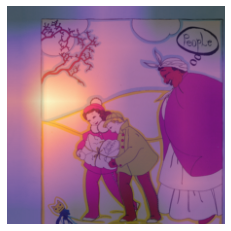

In [56]:
plot_activations('f4811aa9-ac2d-3fd2-8eeb-4cf567f98d98', 5)

09ed5877-bb22-4a26-8ec7-c95e5ee70fd3
d774ed72-8283-426a-b1d2-aafe261cb490
f4811aa9-ac2d-3fd2-8eeb-4cf567f98d98
22356e37-6947-4015-aa08-fe1d739b4cdd
91059fed-fb96-4756-9b9f-463e943d05c2


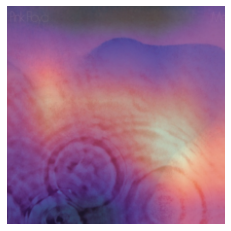

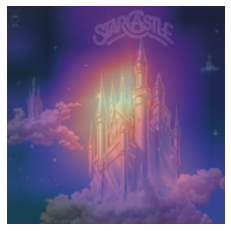

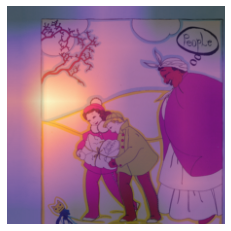

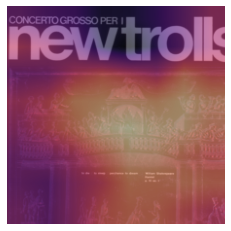

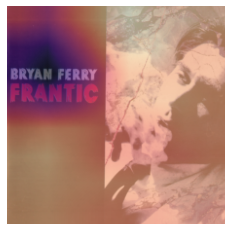

In [53]:
# for n in look_fnl.loc[look_fnl['tags']=='Experimental',:].sample(5)['image_name'].values.tolist():
#     print(n)
#     plot_activations(n, 5)

### Export probabilities

In [45]:
i2o = dict((v,k) for k,v in dls.vocab.o2i.items())
pred_cols = [k for k in dls.vocab.o2i.keys()]

In [46]:
train_probs = learn.get_preds(ds_idx=0, reorder=True)[0]
test_probs = learn.get_preds(reorder=True)[0]

In [47]:
# grab validate predictions
imgs = get_image_files('/storage/thesis/covers/validate/')
dl = learn.dls.test_dl(imgs)
valid_probs = learn.get_preds(dl=dl, with_decoded=True, reorder=True)[0]
img_vec = [str(c).split('/')[-1][:-4] for c in imgs]

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [48]:
img_pred_df = (dt.groupby('image_name')['genre'].max().reset_index().assign(src='valid')
                  .merge(pd.concat([pd.DataFrame(img_vec, columns=['image_name']),
                          pd.DataFrame(np.asarray(valid_probs), columns=pred_cols)], 
                         axis=1),
                         on=['image_name']))

In [49]:
# for train, test, valid, compute probabilities
for d,l,p in zip([dls.train, dls.valid],
                  ['train','test'],
                  [train_probs, test_probs]):
    pred = d.items[['image_name','tags']].reset_index(drop=True).assign(src=l).rename(columns={'tags':'genre'})
    probs = pd.DataFrame(np.asarray(p.cpu()), columns=pred_cols)
    pred = pd.concat([pred, probs], axis=1)
    
    # append to final df
    img_pred_df = pd.concat([img_pred_df, pred])
img_pred_df.to_csv('model_prs/images.csv')

## Time Series for Data

### Data Import

In [26]:
X_on_disk = np.load('/storage/thesis/music_ftr/X_on_disk_samples_v2.npy', mmap_mode='r')
y_on_disk = np.load('/storage/thesis/music_ftr/genres_samples_v2.npy', allow_pickle=True).astype('unicode')
id_on_disk = np.load('/storage/thesis/music_ftr/track_ids_samples_v2.npy', allow_pickle=True)

In [27]:
id_df = pd.DataFrame(id_on_disk, columns=['track_id']).merge(dt, on=['track_id'])
train_idx = L(id_df.loc[id_df['is_test']==0,:].index.tolist())
test_idx = L(id_df.loc[id_df['is_test']==1,:].index.tolist())
splits = (train_idx, test_idx)

# Standardize across all features
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits)

### Model

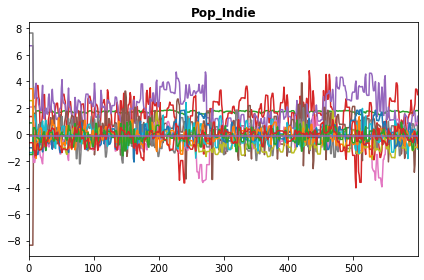

In [74]:
dls1  = (TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, shuffle_train=False,
                                  batch_tfms=[TSStandardize()]))
dls1.train.show_batch(max_n=1, nrows=1, ncols=1, figsize=(6,4))

In [57]:
model = InceptionTime(dls1.vars, dls1.c)
learn = Learner(dls1, model, metrics=[precision, precision2, accuracy])
# learn.lr_find()
learn.fit_one_cycle(5, lr_max=1e-3)
learn.save('ts_1')

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.482889,2.664260,0.191511,0.220902,0.215227,02:34
1,2.362750,2.396563,0.213436,0.250588,0.266622,02:16
2,2.269216,2.311488,0.215696,0.251937,0.286874,02:16
3,2.191329,2.267983,0.237257,0.267446,0.298433,02:16
4,2.145571,2.257850,0.276027,0.288067,0.299198,02:16


/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


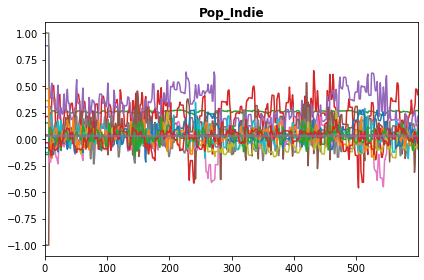

In [73]:
# Normalize (max:1, min:0) across all features
dls2  = (TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, shuffle_train=False,
                                  batch_tfms=[TSNormalize()]))
dls2.train.show_batch(max_n=1, nrows=1, ncols=1, figsize=(6,4))

In [59]:
model2 = InceptionTime(dls2.vars, dls2.c)
learn2 = Learner(dls2, model2, metrics=[precision, precision2, accuracy])
# learn2.lr_find()
learn2.fit_one_cycle(5, lr_max=1e-3)
learn.save('ts_2')

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.596766,2.626820,0.132887,0.179808,0.207203,02:16
1,2.492130,2.525111,0.172242,0.203330,0.229175,02:16
2,2.403406,2.428683,0.192004,0.214237,0.259744,02:16
3,2.330004,2.374952,0.206516,0.235553,0.269775,02:16
4,2.285490,2.356000,0.214753,0.239657,0.275029,02:16


/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


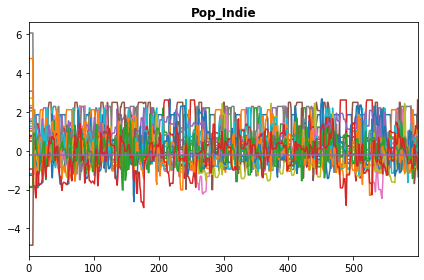

In [28]:
# Standardize for each feature
dls  = (TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, shuffle_train=False,
                                  batch_tfms=[TSStandardize(by_var=True)]))
dls.train.show_batch(max_n=1, nrows=1, ncols=1, figsize=(6,4))

In [61]:
model3 = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model3, metrics=[precision, precision2, accuracy])
# learn3.lr_find()
learn.fit_one_cycle(5, lr_max=1e-3)
learn.save('ts_3')

epoch,train_loss,valid_loss,precision_score,precision_score,accuracy,time
0,2.483516,2.487670,0.174402,0.209060,0.240638,02:16
1,2.378355,2.393972,0.202708,0.241609,0.263565,02:16
2,2.293572,2.341529,0.211573,0.238907,0.275984,02:16
3,2.213551,2.295666,0.249084,0.267732,0.292893,02:16
4,2.168263,2.283329,0.259540,0.278430,0.293752,02:16


/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model3 = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model3, metrics=[precision, precision2, accuracy])
learn.load('ts_3')
learn.model

InceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(25, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(25, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(25, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(25, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))


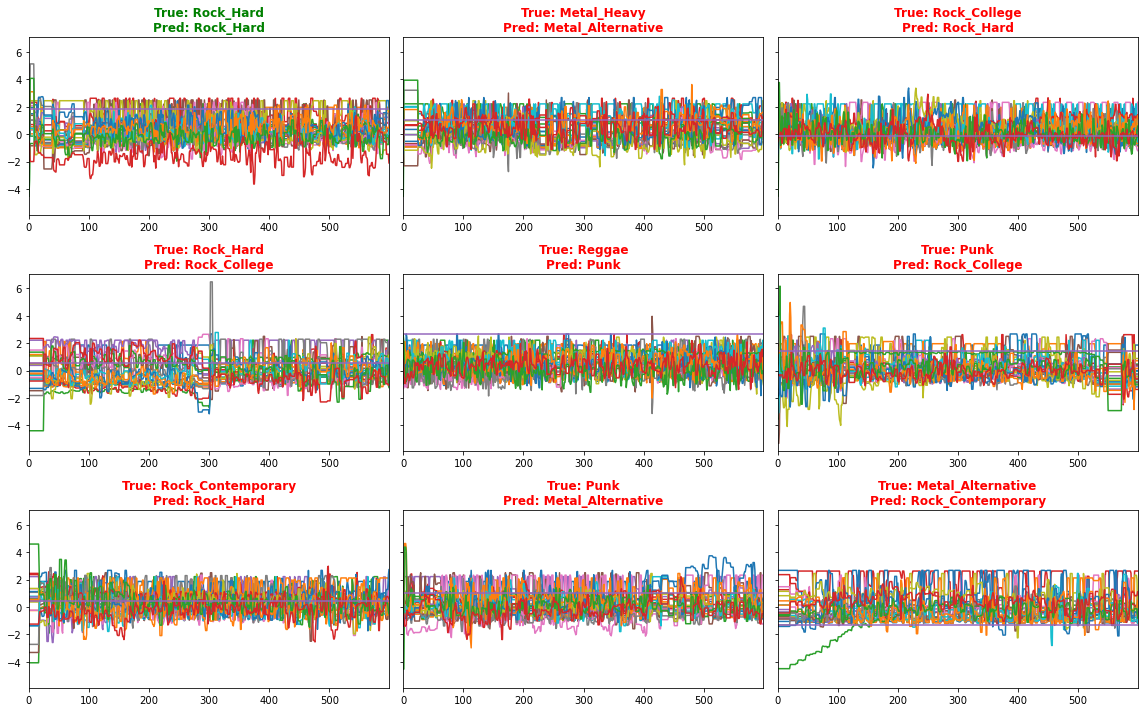

In [62]:
learn.show_results(sharey=True)

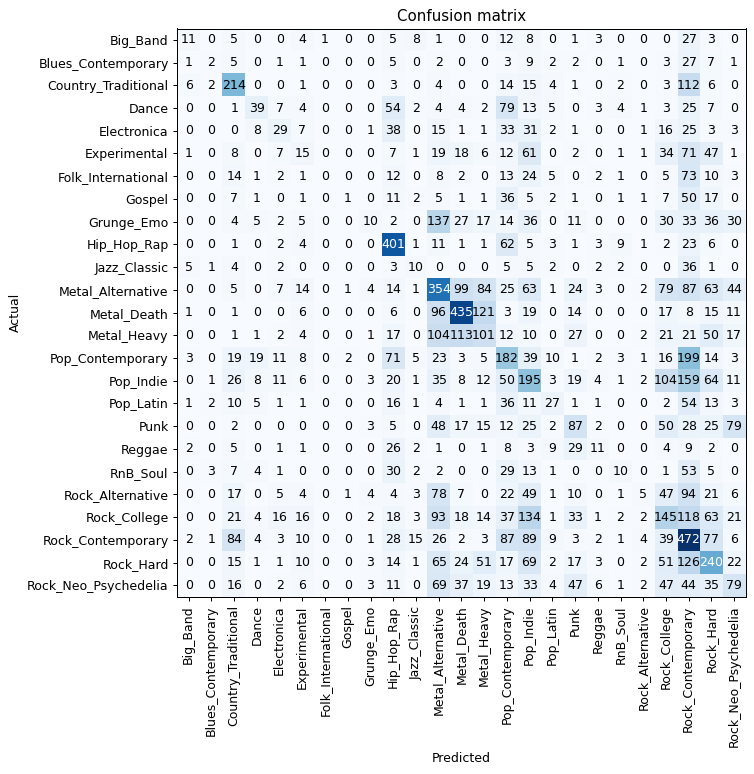

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8.5,8.5), dpi=90)

### Export probabilities

In [64]:
valid_dl = learn.dls.valid

validate_idx = L(id_df.index.tolist())
valid_split = (validate_idx,)

vdsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=valid_split)
test_dl = valid_dl.new(vdsets)

In [65]:
probas = learn.get_preds(dl=test_dl, 
                         with_decoded=True, 
                         reorder=True,
                         save_preds=None, 
                         save_targs=None)[0]

In [66]:
i2o = dict((v,k) for k,v in dls.vocab.o2i.items())
pred_cols = [k for k in dls.vocab.o2i.keys()]

music_pred_df = (pd.concat([id_df.loc[:,'track_id'], 
                            pd.DataFrame(np.asarray(probas.cpu()), columns=pred_cols)], 
                           axis=1))
music_pred_df.to_csv('model_prs/music.csv')